# Overview

The CTHYB solver parameters discussed here are as follows:

1. **n_iw** : Number of Matsubara frequencies used for the Green’s functions.
2. **n_l** : Number of legendre polynomials to use in accumulations of the Green’s functions.
3. **length_cycle** : Length of one cycle
4. **n_warmup_cycles** : Warmup cycles
5. **n_cycles** : Number of QMC cycles
6. **n_tau**

In [1]:
import numpy as np
from math import pi
from triqs.gf import *
from triqs.plot.mpl_interface import oplot,plt
from matplotlib import pyplot
from triqs.gf import make_gf_from_fourier
from triqs.operators import *
from h5 import *
from h5 import HDFArchive
from triqs_cthyb import Solver

# Make plots show up directly in the notebook:
%matplotlib inline

# Make all figures slightly bigger
import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

Starting serial run at: 2022-07-18 16:17:40.401854


#
## n_iw

We plot the density of the Green's function for different sizes of the frequency mesh. The density converges to a value of 0.5 (why?). As can be seen for a smaller beta, it converges faster.

 Error = 0.000325165
 Please make sure you treat the constant offset analytically!
/cm/shared/sw/nix/store/h67ird3i9fcnd25n8j7y61n75ifp8vsq-py-numpy-1.20.3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
 Error = 0.00714609
 Please make sure you treat the constant offset analytically!


Text(0.5, 0, '$i\\omega_{max}$')

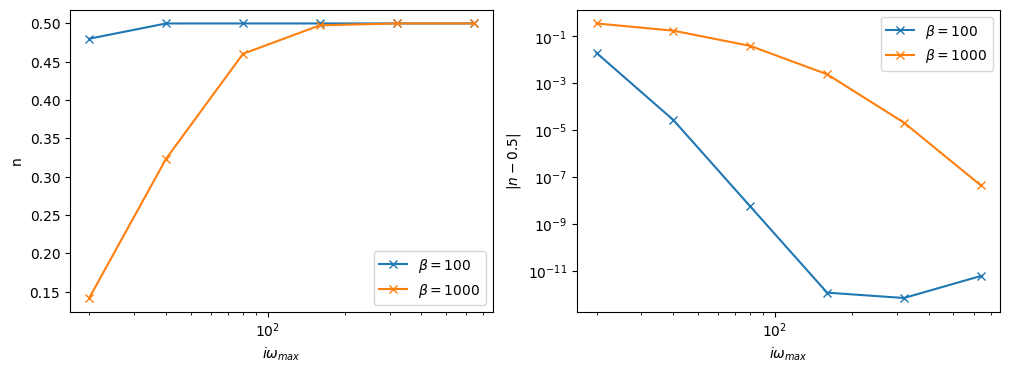

In [2]:
ig, ax = plt.subplots(1, 2, figsize=(12, 4))
D = 1  # Half bandwidth
beta = [100, 1000]
n_max = [20, 40, 80, 160, 320, 640]
for i in range(len(beta)):
    d = []
    for j in range(len(n_max)):
        iw_mesh = MeshImFreq(beta=beta[i], S='Fermion', n_max=n_max[j])
        G = Gf(mesh=iw_mesh, target_shape=[])
        G << SemiCircular(D)
        d.append(G.density())
    ax[0].set_xscale("log")
    ax[0].plot(n_max, d, '-x', label=r"$\beta = %i$"%beta[i])
    d = list(map(lambda x: x - 0.5, d))
    d = list(map(abs, d))
    ax[1].set_xscale("log")
    ax[1].set_yscale("log")
    ax[1].plot(n_max, d, '-x', label=r"$\beta = %i$"%beta[i])

ax[0].legend(loc="best")
ax[0].set_xlabel('$i\omega_{max}$')
ax[0].set_ylabel('n')
ax[1].set_ylabel('$|n-0.5|$')
ax[1].legend()
ax[1].set_xlabel('$i\omega_{max}$')

We can also look at the Green's function and see how close the tails are to zero for each frquency mesh.

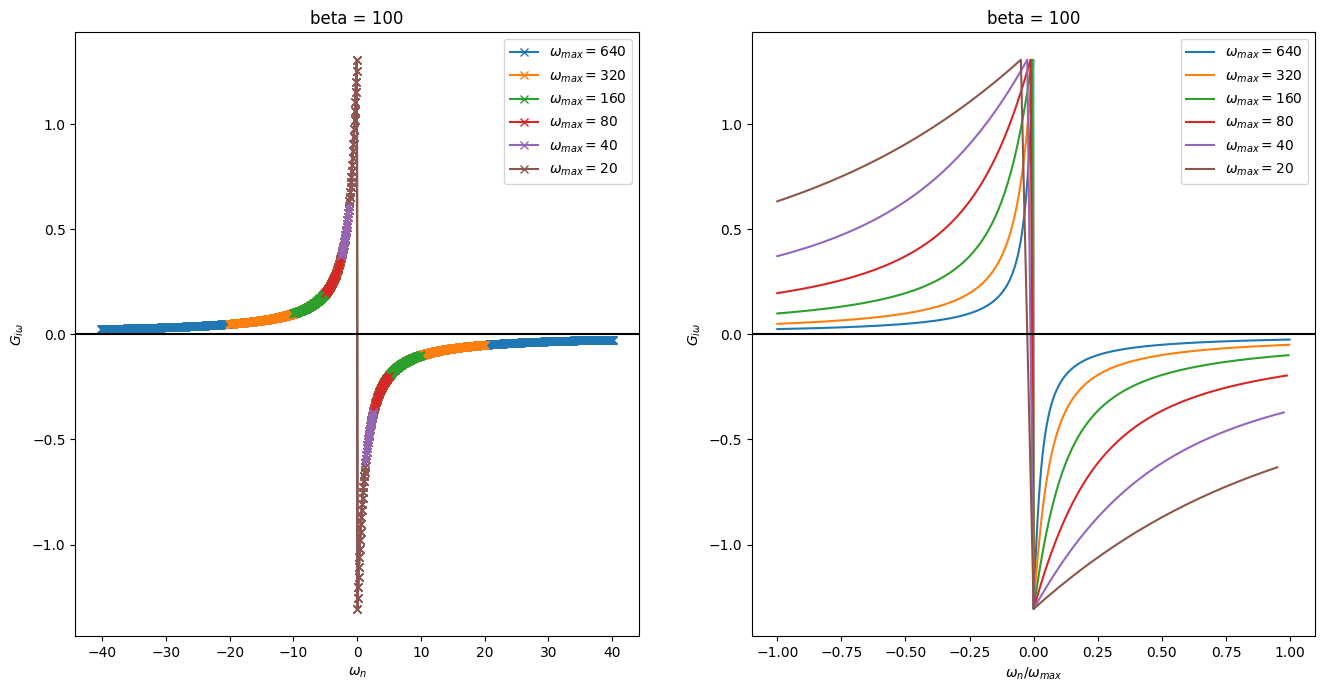

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
D = 1.5  # Half bandwidth
beta = 100
n_max = [640, 320, 160, 80, 40, 20]
for j in range(len(n_max)):
    a = np.arange(-n_max[j],n_max[j])
    iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_max=n_max[j])
    G = Gf(mesh=iw_mesh, target_shape=[1,1])
    G << SemiCircular(D)
    ax[0].oplot(G.imag, '-x', label=r"$\omega_{max}= %i$"%n_max[j])
    ax[1].plot(a/n_max[j], G.imag.data[:,0], label=r"$\omega_{max}= %i$"%n_max[j])
ax[0].set_ylabel("$G_{i\omega}$")
ax[0].set_title("beta = %i"%beta)
ax[0].axhline(color='k')

plt.legend()
ax[1].set_ylabel("$G_{i\omega}$")
ax[1].set_xlabel("$\omega_n/\omega_{max}$")
ax[1].set_title("beta = %i"%beta)
ax[1].axhline(color='k')

#

## n_l

We first need to define a function that transforms the Green's function from imaginary time to legendre.

In [4]:
from triqs.gf import BlockGf
from triqs.gf.tools import fit_legendre

def apply(G_tau, order=100, G_l_cut=1e-19):
    """ Filter binned imaginary time Green's function
    using a Legendre filter of given order and coefficient threshold.
    Parameters
    ----------
    G_tau : TRIQS imaginary time Block Green's function
    auto : determines automatically the cut-off nl
    order : int
        Legendre expansion order in the filter
    G_l_cut : float
        Legendre coefficient cut-off
    Returns
    -------
    G_l : TRIQS Legendre Block Green's function
        Fitted Green's function on a Legendre mesh
    """

    l_g_l = []

    for _, g in G_tau:

        g_l = fit_legendre(g, order=order)
        g_l.data[:] *= (np.abs(g_l.data) > G_l_cut)
        g_l.enforce_discontinuity(np.identity(g.target_shape[0]))

        l_g_l.append(g_l)

    G_l = BlockGf(name_list=list(G_tau.indices), block_list=l_g_l)

    return G_l

Here we creat a block Green's function (because the function above only works for block Gfs) in imaginary frequency and initiallize it with Semi-circular density of state. Then fourier transform it to imaginary time and finally use the function defined in the previous cell to transform it to a Legendre Green's function.

In [5]:
beta=100
tau_mesh = MeshImTime(beta=beta, S='Fermion', n_max=100)
iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_max=100)
gf_struct = [('eg',2), ('t2g',3)]
gw = BlockGf(mesh=iw_mesh, gf_struct=gf_struct)
gw << SemiCircular(half_bandwidth = 1)
gtau = make_gf_from_fourier(gw)
gl = apply(gtau, order=100, G_l_cut=1e-19)

This cell separates the odd and even parts of the Legendre Green's function and the convergence tells us how many Legendre plynomials we need to keep in our calcualtion.

Text(0, 0.5, '$|G_l|$')

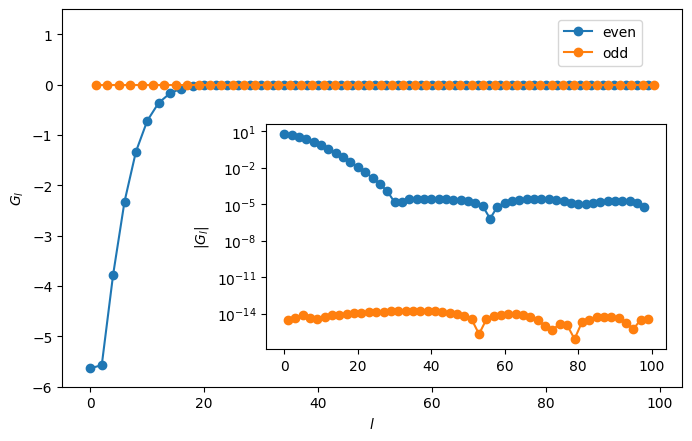

In [6]:
fig, ax1 = plt.subplots(figsize=(8, 5))
left, bottom, width, height = [0.38, 0.2, 0.5, 0.45]
ax2 = fig.add_axes([left, bottom, width, height])
d_even=[]
d_odd=[]
x_even=np.arange(0,100,2)
x_odd=np.arange(1,100,2)
for i in range(0,100,2):
    d_even.append(gl['t2g'].real.data[i,0][0])
for k in range(1,100,2):
    d_odd.append(gl['t2g'].real.data[k,0][0])
ax1.plot(x_even, d_even, '-o', label='even')
ax1.plot(x_odd, d_odd, '-o', label='odd')
d_even_abs= list(map(abs, d_even))
d_odd_abs= list(map(abs, d_odd))
ax2.plot(x_even, d_even_abs, '-o')
ax2.plot(x_odd, d_odd_abs, '-o')
pyplot.yscale('log')
ax1.set_ylim(-6,1.5)
ax1.legend(loc=(0.8,0.85))
ax1.set_xlabel('$l$')
ax1.set_ylabel('$G_l$')
ax2.set_ylabel('$|G_l|$')

#
## length_cycle

We use a single orbital Hubbard model at half-filling and plot the Green's function in imagniary time (G_tau) obtained from the slover for different number of n_cycles. As you can see, larger n_cycles gives a smoother G_tau. 

In [7]:
import os
if not os.path.exists('data/len_cyc_b10'):
    os.makedirs('data/len_cyc_b10')
    
t = 1.0
beta = 10
n_loops = 1
U = 2.0
mu = 0.0
length_cycle = np.arange(20,200,20)
# Construct the impurity solver

# I run for several values of U
for j in range(len(length_cycle)):
    S = Solver(beta = beta, gf_struct = [('up',1), ('down',1)])
    S.G_iw << SemiCircular(2*t)
    # DMFT loop with self-consistency
    for i in range(n_loops):
    
        print("\n\nIteration = %i / %i" % (i+1, n_loops))
        # Symmetrize the Green's function and use self-consistency
        g = 0.5 * ( S.G_iw['up'] + S.G_iw['down'] )
        for name, g0 in S.G0_iw:
            g0 << inverse( iOmega_n + U/2.0 - mu - t**2 * g )

        # Solve the impurity problem
        S.solve(h_int = U * n('up',0) * n('down',0),   # Local Hamiltonian 
            n_cycles  = 500000,                           # Number of QMC cycles
            length_cycle = length_cycle[j],
            n_warmup_cycles = 3000,                      # Warmup cycles
            )
        print(S.G_iw.density())
        # Save iteration in archive
        with HDFArchive("data/len_cyc_b10/half-U%i.h5"%length_cycle[j]) as A:
            A['a%i'%i] = S.auto_corr_time



Iteration = 1 / 1

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-1*c_dag('down',0)*c('down',0) + -1*c_dag('up',0)*c('up',0) + 2*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:34:39  39% ETA 00:00:00 cycle 1189 of 3000



Accumulating ...
12:34:39   0% ETA 00:00:40 cycle 1241 of 500000
12:34:41   5% ETA 00:00:39 cycle 26220 of 500000
12:34:44  11% ETA 00:00:35 cycle 58433 of 500000
12:34:47  19% ETA 00:00:32 cycle 97438 of 500000
12:34:51  29% ETA 00:00:28 cycle 146553 of 500000
12:34:56  41% ETA 00:00:23 cycle 209003 of 500000
12:35:02  57% ETA 00:00:17 cycle 285235 of 500000
12:35:10  76% ETA 00:00:09 cycle 380302 of 500000
12:35:20  99% ETA 00:00:00 cycle 499648 of 500000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures

Insert error : recovering ... 





Iteration = 1 / 1

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-1*c_dag('down',0)*c('down',0) + -1*c_dag('up',0)*c('up',0) + 2*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:40:17  10% ETA 00:00:00 cycle 307 of 3000



Accumulating ...
12:40:18   0% ETA 00:01:56 cycle 430 of 500000
12:40:20   1% ETA 00:01:56 cycle 8991 of 500000
12:40:23   3% ETA 00:01:53 cycle 19751 of 500000
12:40:26   6% ETA 00:01:50 cycle 33095 of 500000
12:40:30   9% ETA 00:01:46 cycle 49733 of 500000
12:40:35  14% ETA 00:01:41 cycle 70502 of 500000
12:40:41  19% ETA 00:01:35 cycle 96542 of 500000
12:40:49  25% ETA 00:01:27 cycle 129320 of 500000
12:40:58  33% ETA 00:01:18 cycle 169992 of 500000
12:41:10  44% ETA 00:01:06 cycle 220807 of 500000
12:41:25  56% ETA 00:00:51 cycle 284138 of 500000
12:41:44  72% ETA 00

Insert error : recovering ... 


ank 0] Simulation lasted: 118.8 seconds [00:01:58]
[Rank 0] Number of measures: 500000
Total number of measures: 500000
Average sign: 1
Average order: 7.76132
Auto-correlation time: 0.622599
{'up': array([[0.50010228+4.10504733e-15j]]), 'down': array([[0.50899033+4.14954299e-15j]])}


Iteration = 1 / 1

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-1*c_dag('down',0)*c('down',0) + -1*c_dag('up',0)*c('up',0) + 2*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:42:17  10% ETA 00:00:00 cycle 321 of 3000



Accumulating ...
12:42:18   0% ETA 00:02:17 cycle 363 of 500000
12:42:20   1% ETA 00:02:15 cycle 7741 of 500000
12:42:22   3% ETA 00:02:12 cycle 16940 of 500000
12:42:26   5% ETA 00:02:09 cycle 28383 of 500000
12:42:30   8% ETA 00:02:06 cycle 42607 of 500000
12:42:34  12% ETA 00:02:01 cycle 60

Insert error : recovering ... 
Insert error : recovering ... 



╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
{'up': array([[0.50028812+4.10426671e-15j]]), 'down': array([[0.50169921+4.046392e-15j]])}-1*c_dag('down',0)*c('down',0) + -1*c_dag('up',0)*c('up',0) + 2*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
12:44:36  10% ETA 00:00:00 cycle 323 of 3000



Accumulating ...
12:44:37   0% ETA 00:02:39 cycle 313 of 500000
12:44:39   1% ETA 00:02:35 cycle 6746 of 500000
12:44:42   2% ETA 00:02:32 cycle 14795 of 500000
12:44:45   4% ETA 00:02:29 cycle 24833 of 500000
12:44:49   7% ETA 00:02:25 cycle 37332 of 500000
12:44:54  10% ETA 00:02:21 cycle 52863 of 500000
12:45:00  14% ETA 00:02:15 cycle 72365 of 500000
12:45:08  19% ETA 00:02:07 cycle 96960 of 500000
12:45:18  25% ETA 00:01:57 cycle 127567 of 500000
12:45:30  33% ETA 00:01:45 cycle 165744 of 500000
12

Insert error : recovering ... 


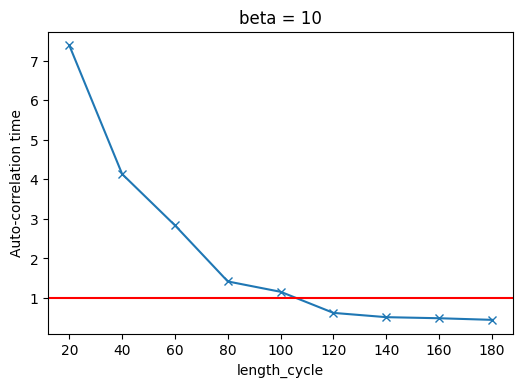

In [8]:
d = []
for j in range(len(length_cycle)):
    A1 = HDFArchive("data/len_cyc_b10/half-U%i.h5"%length_cycle[j], 'r')
    d.append(A1['a0'])
# print(d)
plt.plot(length_cycle, d, '-x')
plt.ylabel('Auto-correlation time')
plt.xlabel('length_cycle')
plt.title('beta = 10')
plt.axhline(y=1, color='r')

Text(0.5, 1.0, 'n_warmup=0')

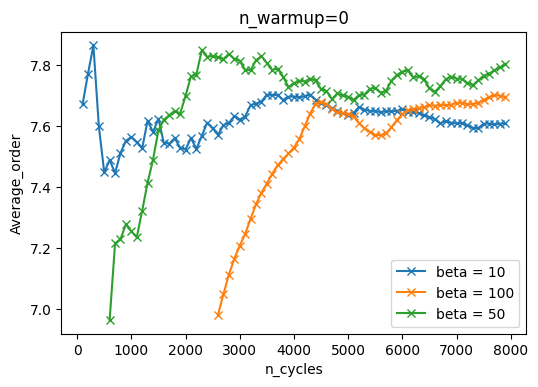

In [5]:
d1 = []
d2 = []
d3 = []
n_cycles = np.arange(100,8000,100)
for j in range(len(n_cycles)):
    A1 = HDFArchive("data/warm_up/half-U%i.h5"%n_cycles[j], 'r')
    d1.append(A1['a0'])
    A2 = HDFArchive("data/warm_up_b100/half-U%i.h5"%n_cycles[j], 'r')
    d2.append(A2['a0'])
    A3 = HDFArchive("data/warm_up_b50/half-U%i.h5"%n_cycles[j], 'r')
    d3.append(A3['a0'])
d2=list(map(lambda x: x/9.5, d2))
d3=list(map(lambda x: x/5, d3))
plt.plot(n_cycles, d1, '-x', label='beta = 10')
plt.plot(n_cycles[25:], d2[25:], '-x', label='beta = 100')
plt.plot(n_cycles[5:], d3[5:], '-x', label='beta = 50')
plt.legend()
plt.ylabel('Average_order')
plt.xlabel('n_cycles')
plt.title('n_warmup=0')

In [6]:
import os
if not os.path.exists('data/check'):
    os.makedirs('data/check')
    
# Parameters of the model
t = 1.0
beta = 10
n_loops = 1
U = 2.0
n_cycles = [32000, 64000, 128000, 256000, 512000, 1024000, 2048000]
# Construct the impurity solver

# I run for several values of U
for j in range(len(n_cycles)):
    print('n_cycles =', n_cycles[j])
    S = Solver(beta = beta, gf_struct = [('up',1), ('down',1)])
    # This is a first guess for G
    S.G_iw << SemiCircular(2*t)

    # DMFT loop with self-consistency
    for i in range(n_loops):
    
        print("\n\nIteration = %i / %i" % (i+1, n_loops))
        # Symmetrize the Green's function and use self-consistency
        g = 0.5 * ( S.G_iw['up'] + S.G_iw['down'] )
        for name, g0 in S.G0_iw:
            g0 << inverse( iOmega_n + U/2.0 - t**2 * g )

        # Solve the impurity problem
        S.solve(h_int = U * n('up',0) * n('down',0),   # Local Hamiltonian 
            n_cycles  = n_cycles[j],                           # Number of QMC cycles
            length_cycle = 100,
            n_warmup_cycles = 4000,                      # Warmup cycles
            )
    
        # Save iteration in archive
        with HDFArchive("data/check/half-U%i.h5"%n_cycles[j]) as A:
            A['Gtau-%i'%i] = S.G_tau
            A['G-%i'%i] = S.G_iw
            A['Sigma-%i'%i] = S.Sigma_iw

n_cycles = 32000


Iteration = 1 / 1

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-1*c_dag('down',0)*c('down',0) + -1*c_dag('up',0)*c('up',0) + 2*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
16:22:06   0% ETA 00:00:19 cycle 36 of 4000
16:22:08  54% ETA 00:00:01 cycle 2178 of 4000



Accumulating ...
16:22:10   0% ETA 00:00:31 cycle 101 of 32000
16:22:12   7% ETA 00:00:26 cycle 2397 of 32000
16:22:15  18% ETA 00:00:20 cycle 5945 of 32000
16:22:18  35% ETA 00:00:14 cycle 11481 of 32000
16:22:22  56% ETA 00:00:09 cycle 18141 of 32000
16:22:27  83% ETA 00:00:03 cycle 26706 of 32000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.108244  
Average order         | 0.00

Insert error : recovering ... 


 Remove Delta_up_up: 0.0272865
  Move  Remove Delta_up_down: 0.0224241
  Move  Remove Delta_down_up: 0.022327
  Move  Remove Delta_down_down: 0.0271853
Move  Shift one operator: 0.700142
[Rank 0] Warmup lasted: 2.52128 seconds [00:00:02]
[Rank 0] Simulation lasted: 282.175 seconds [00:04:42]
[Rank 0] Number of measures: 512000
Total number of measures: 512000
Average sign: 1
Average order: 7.76386
Auto-correlation time: 1.17695
n_cycles = 1024000


Iteration = 1 / 1

╔╦╗╦═╗╦╔═╗ ╔═╗  ┌─┐┌┬┐┬ ┬┬ ┬┌┐ 
 ║ ╠╦╝║║═╬╗╚═╗  │   │ ├─┤└┬┘├┴┐
 ╩ ╩╚═╩╚═╝╚╚═╝  └─┘ ┴ ┴ ┴ ┴ └─┘

The local Hamiltonian of the problem:
-1*c_dag('down',0)*c('down',0) + -1*c_dag('up',0)*c('up',0) + 2*c_dag('down',0)*c_dag('up',0)*c('up',0)*c('down',0)
Using autopartition algorithm to partition the local Hilbert space
Found 4 subspaces.

Warming up ...
16:31:47   1% ETA 00:00:15 cycle 47 of 4000



Accumulating ...
16:31:49   0% ETA 00:09:29 cycle 179 of 1024000
16:31:51   0% ETA 00:09:10 cycle 4003 of 1024000
16:31:54   0% 

Insert error : recovering ... 


 00:05:44 cycle 347852 of 1024000
16:35:33  42% ETA 00:05:07 cycle 431793 of 1024000
16:36:31  53% ETA 00:04:07 cycle 545091 of 1024000
16:37:43  66% ETA 00:02:55 cycle 684935 of 1024000
16:39:14  82% ETA 00:01:31 cycle 849434 of 1024000


[Rank 0] Collect results: Waiting for all mpi-threads to finish accumulating...
[Rank 0] Timings for all measures:
Measure               | seconds   
Auto-correlation time | 0.612676  
Average order         | 0.349006  
Average sign          | 0.238501  
G_tau measure         | 1.3205    
Total measure time    | 2.52068   
[Rank 0] Acceptance rate for all moves:
Move set Insert two operators: 0.126174
  Move  Insert Delta_up: 0.126247
  Move  Insert Delta_down: 0.1261
Move set Remove two operators: 0.126373
  Move  Remove Delta_up: 0.126396
  Move  Remove Delta_down: 0.126349
Move set Insert four operators: 0.0249102
  Move  Insert Delta_up_up: 0.0273235
  Move  Insert Delta_up_down: 0.0225703
  Move  Insert Delta_down_up: 0.0224032
  Move  Insert De

Insert error : recovering ... 


Text(0, 0.5, '$G_{tau}$')

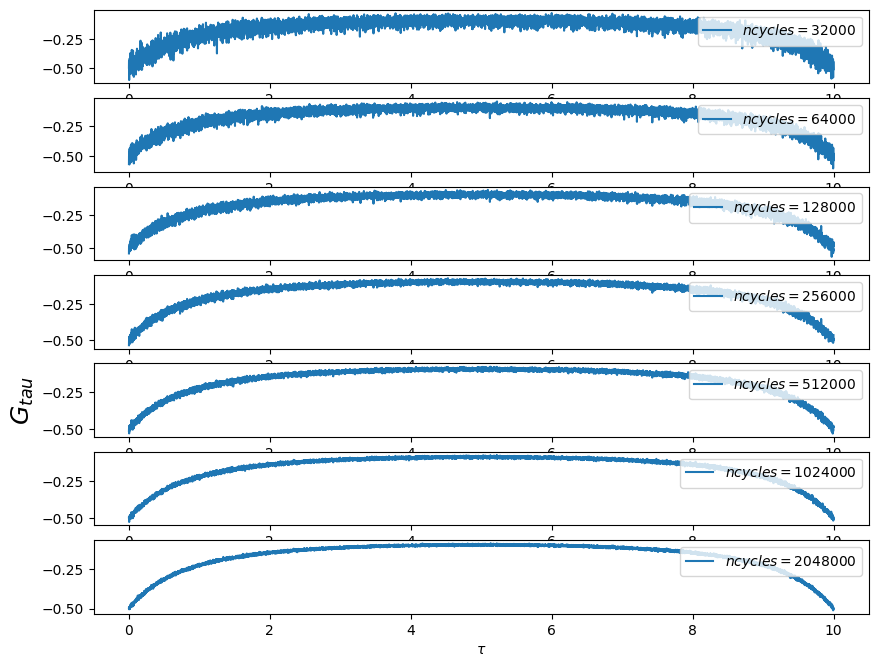

In [7]:
fig, ax = plt.subplots(7, 1, figsize=(10, 8))
n_cycles = [32000, 64000, 128000, 256000, 512000, 1024000, 2048000]
for j in range(len(n_cycles)):
    A1 = HDFArchive("data/check/half-U%i.h5"%n_cycles[j], 'r')
    ax[j].oplot(A1['Gtau-0']['up'].real, '-', label=r"$ncycles = %i$"%n_cycles[j])
    ax[j].set_ylabel('')
ax[4].set_ylabel('$G_{tau}$', fontsize="18")